<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Reviewers comment v1</h1>

Hello Avon!

I'm happy to review your project today 🙌

My name is **Justino Imbert** ([this](https://hub.tripleten.com/u/125e88ae) is my Hub profile) and today I'll be reviewing your project!


You can find my comments under the heading **«Review»**. I will categorize my comments in green, yellow, red or blue boxes like this:

<div class="alert alert-success">
    <b>Success:</b> if everything is done successfully
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> if I can give some recommendations or ways to improve the project
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> if the block requires some corrections. Work cant be accepted with the red comments
</div>

Please dont remove my comments :) If you have any questions dont hesitate to respond to my comments in a different section. 
<div class="alert alert-info"> <b>Student comments:</b> For example like this</div>    

<div class="alert alert-block alert-info">
<b>Reviewer's comment v1:</b> </a>

You did an incredible job on this project!! Your attention to detail and genuine curiosity really stood out throughout your work! Your code was really well organized!

I’m really looking forward to reviewing your next submissions, keep up the great work, and best of luck!!!

</div>

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('/datasets/car_data.csv')

In [2]:
print(data.info())

# re-formatting column names
data = data.rename(columns = {'DateCrawled' : 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type',
                              'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power',
                              'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month',
                              'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'repaired',
                              'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures',
                              'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

print(data.isna().sum())
display(data.describe())
#print(data.sample(30, random_state=777))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**- ['not_repaired'] is a bit confusing at first, not_repaired == no ... is a double negative, but documentation states "Vehicle repaired or not", so no = no. For clarity I will be changing the name of this column to simply ['repaired'].**

**- ['number_of_pictures'] is completely filled with zeros, we will be removing this from the features since it has no value to our training.**

**- ['registration_month'] has zero values, but this doesn't make logical sense, becuase month range is (1 - January) to (12 - December)**

**- ['registration_year'] has values as low as 1000, and as high as 9999, also some vehicles are registered past the year of data extraction (2016), meaning time travel?**

**- Registration date does in fact impact vehicle resale value in the European Union, hence the target variable Price(euros), so we will be keeping these columns for training.**

**- ['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'] have no predictive power in relation to model training, so these will be removed.**

In [3]:
print('BEFORE:\nnumber of vehicles registered before the year 1960: ', (data['registration_year'] < 1960).sum())
print('number of vehicles registered after 2016: ', (data['registration_year'] > 2016).sum())
print('number of vehicles registered in the month 0: ', (data['registration_month'] < 1).sum())
#print(data[data['registration_year'] < 1960])
#print(data[data['registration_year'] > 2016])

# removing entries of vehicles registered before 1898 & after 2016 (all data was crawled during the year 2016, cars registered in 2018 are paradoxical)
data = data[(data['registration_year'] >= 1960) & (data['registration_year'] <= 2016)]

# replacing registration_month == 0, with the mean
mean_month = data.loc[data['registration_month'] != 0, 'registration_month'].mean()
data.loc[data['registration_month'] == 0, 'registration_month'] = round(mean_month)

print('AFTER:\nnumber of vehicles registered before the year 1960: ', (data['registration_year'] < 1960).sum())
print('number of vehicles registered after 2016: ', (data['registration_year'] > 2016).sum())
print('number of vehicles registered in the month 0: ', (data['registration_month'] < 1).sum())

BEFORE:
number of vehicles registered before the year 1960:  422
number of vehicles registered after 2016:  14530
number of vehicles registered in the month 0:  37352
AFTER:
number of vehicles registered before the year 1960:  0
number of vehicles registered after 2016:  0
number of vehicles registered in the month 0:  0


**- The Netherlands was the first country to ever require vehicle registration in the year 1898, so any registrations before this date are invalid, but for the sake of training a model focused on the mainstream market, we will be applying a lower limit of 1960, with an upper limit of 2016 (year of data).**

**- All data was captured during the year 2016, so cars registered in 2017 onward are logically impossible. The upper limit of this feature is 9999, proving that we have impossible values within this column. These amount for roughly ~4% of our data set, so they are safe for removal.**

**- Month values range from 1-12, 0 values are replaced with the mean.**

In [4]:
display(data.describe())
#print(data.info())
#display(data.loc[(data['power'] >= 500) | (data['power']  <= 30)])
#display(data.loc[data['price'] < 100])

print('BEFORE:\nnumber of vehicles with (30 < power < 500): ', ((data['power'] > 500) | (data['power']  < 30)).sum())
print('number of vehicles with (price < 100): ', (data['price'] < 100).sum())

# removing entries of vehicles with power less than 30, or exceeding 500
data = data[(data['power'] >= 30) & (data['power'] <= 500)]

# removing entries of vehicles with price < 100, this is most likely a bait to place their vehicle higher in the listing system
data = data[(data['price'] >= 100)]

print('AFTER:\nnumber of vehicles with (30 < power < 500): ', ((data['power'] > 500) | (data['power']  < 30)).sum())
print('number of vehicles with (price < 100): ', (data['price'] < 100).sum())

display(data.describe())
#print(data.info())
#display(data.loc[(data['power'] > 500) | (data['power']  < 30)])
#display(data.loc[data['price'] < 100])

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,339417.000000,339417.000000,339417.000000,339417.000000,339417.000000,339417.0,339417.000000
mean,4469.893187,2002.549669,111.075341,128152.641146,6.351102,0.0,50608.841428
std,4543.692216,6.752035,186.925261,37813.605479,3.182562,0.0,25803.571234
min,0.000000,1960.000000,0.000000,5000.000000,1.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,4.000000,0.0,30169.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49492.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


BEFORE:
number of vehicles with (30 < power < 500):  37522
number of vehicles with (price < 100):  12349
AFTER:
number of vehicles with (30 < power < 500):  0
number of vehicles with (price < 100):  0


,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,294388.000000,294388.000000,294388.000000,294388.000000,294388.000000,294388.0,294388.000000
mean,4872.632329,2002.892886,120.854865,128469.706646,6.359295,0.0,51261.347371
std,4609.434838,6.357164,53.318752,36539.697450,3.247446,0.0,25761.479908
min,100.000000,1960.000000,30.000000,5000.000000,1.000000,0.0,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,4.000000,0.0,30952.000000
50%,3200.000000,2003.000000,112.000000,150000.000000,6.000000,0.0,50321.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


**- After some research on the used car market, I've established some boundaries for our numerical feature ranges. This way, our model will be trained on realistic data, and not on anomalous data such as 20000 power, or registration year 9999, etc. These paradoxical entries are either data entry errors, or ways to manipulate the listing system (price 0 will show at the top of the list sorted by price ascending). Either way, this data is not useful in relation to our model.**

**- 'registration_month' = 0, has been replaced with the rounded mean value (6)**

**- 'registration_year', has been limited to entries between the ranges of 1960 to 2016, this gives us relevant data reflecting a realistic market. Even if it is possible that a car from the 1920's is for sale, 75% of our data was between 1999 to 2016, so bringing the lower bound closer gives our model a more stable environment to learn.**

**- 'power', has been limited to entries between the ranges of 30 to 500, for the same reason as above. 75% of our data was between 69 to 143, 0 makes no sense, and 20000 is absurd. Bringing our boundaries much closer to the majority distribution creates a more realistic setting for training.**

**- 'price', only had it's lower limit raised from 0 to 100. It's possible that someone could be selling a low power, older vehicle for quick cash. However, anything lower than this already low value, is most likely an input error, or an attempt to place their listing higher in the list when sorted by price ascending. This lower boundary, even though less than 10% of our lower quartile (Q1: 1350), still represents realistic data, which is what we are striving for in the data cleaning process.**

**- There are still plenty of missing values in ['vehcile_type', 'gearbox', 'model', 'fuel_type', 'repaired'] we have to handle, but our numerical columns have been cleaned. The next section will analyze the numerical columns distributions via boxplots.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

AMAZING job analyzing the data! You did a really in-depth exploration that shows how committed you are to the project!

Looking good!

</div>

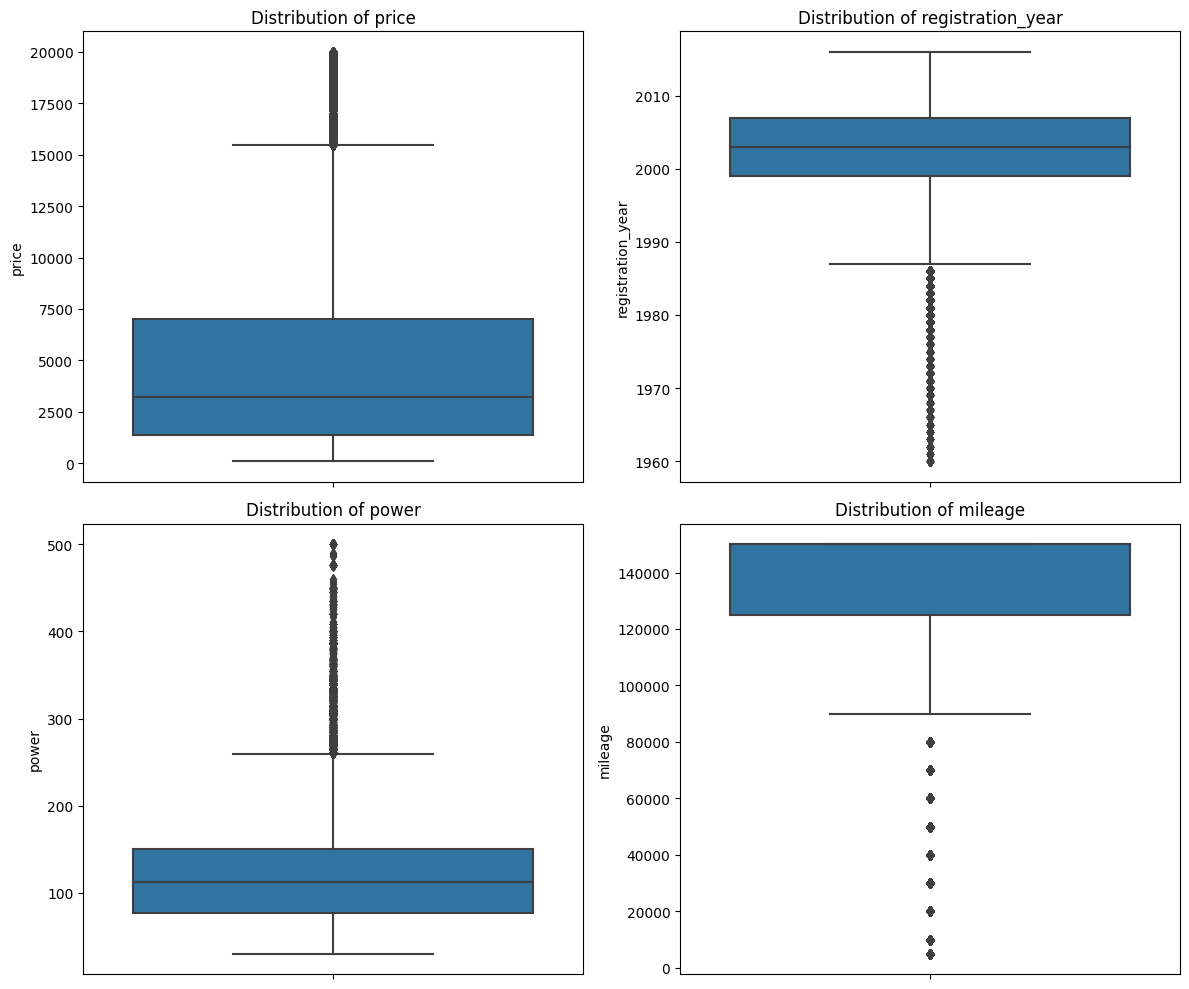

In [5]:
# plotting altered numerical column distributions 
numerical_distribution_check = ['price', 'registration_year', 'power', 'mileage']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, feature in zip(axes.flatten(), numerical_distribution_check):
    sns.boxplot(y=data[feature], ax=ax)
    ax.set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

**- Our distributions are looking much, much better after applying the new boundaries for outliers, more closely resembling the vast range of vehicles in a realistic used car market.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Great job with the data visualization! Box plots are looking good!
    
</div>

In [6]:
# missing = ['vehcile_type', 'gearbox', 'model', 'fuel_type', 'repaired']

print('-------MISSING-BEFORE-------\n',data.isna().sum())

data['vehicle_type'] = data['vehicle_type'].fillna('unknown_vehicle_type')
data['gearbox'] = data['gearbox'].fillna('unknown_gearbox')
data['model'] = data['model'].fillna('unkown_model')
data['fuel_type'] = data['fuel_type'].fillna('unknown_fuel_type')
data['repaired'] = data['repaired'].fillna('unknown_repaired')

print('------MISSING-AFTER-------\n',data.isna().sum())

print(data.info())

-------MISSING-BEFORE-------
 date_crawled              0
price                     0
vehicle_type          10766
registration_year         0
gearbox                5186
power                     0
model                 10786
mileage                   0
registration_month        0
fuel_type             15213
brand                     0
repaired              42265
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64
------MISSING-AFTER-------
 date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294388 entries, 1 to 354368
Data c

**- I've replaced the missing values in our categorical columns with 'unknown_{feature}', giving us full columns without introducing bias, treating the missing values as their own category. We're now ready to move onto preprocessing/model training.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Beautiful job handling the missing values! Assigning `unknown_{feature}` where data was missing is a clear and consistent approach!

</div>

In [7]:
from sklearn.model_selection import train_test_split

# 80:20 - (train + val):test
train_val, test = train_test_split(data, test_size=.2, random_state=99)

# 60:20 - train:val
train, val = train_test_split(train_val, test_size=.25, random_state=99)

# features separate by dtype
numerical = ['registration_year', 'power', 'mileage', 'registration_month']
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# prediction target
target = ['price']

# 60:20:20 - train:valid:test - features
train_features = train[numerical + categorical]
valid_features = val[numerical + categorical]
test_features = test[numerical + categorical]

# 60:20:20 - train:valid:test - target
train_target = train[target]
valid_target = val[target]
test_target = test[target]

#print(train_features.info())
#print(valid_features.info())
#print(test_features.info())

#print(train_target.info())
#print(valid_target.info())
#print(test_target.info())

**- Our data is now split and contains only the features with predictive power, 3 sets for training-validation-testing.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Good job splitting the data!

</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

It’s really easy to follow your code, the way you explain each step makes it very clear and organized! Keep up the good work!

</div>

## Model training

In [8]:
# LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
scaler.fit(train_features[numerical])

def numerical_scaler(features):
    return scaler.transform(features[numerical])

def categorical_encoder(features):
    return pd.get_dummies(features, drop_first=True)

def sanity_benchmark(train_features, valid_features, test_features, train_target, valid_target, test_target):
    train_ohe = categorical_encoder(train_features) # OHE train features
    valid_ohe = categorical_encoder(valid_features) # OHE valid features
    test_ohe = categorical_encoder(test_features) # OHE test features
    valid_ohe = valid_ohe.reindex(columns=train_ohe.columns, fill_value=0) # realign valid columns with train
    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0) # realign test columns with train
    train_ohe[numerical] = numerical_scaler(train_ohe) # train numerical scaling
    valid_ohe[numerical] = numerical_scaler(valid_ohe) # valid numerical scaling
    test_ohe[numerical] = numerical_scaler(test_ohe) # test numerical scaling
    model = LinearRegression() # model initiation
    model.fit(train_ohe, train_target) # model trained 
    val_predictions = model.predict(valid_ohe) # validation target predictions
    validation_score = mean_squared_error(valid_target, val_predictions) ** .5 # RMSE validation predictions
    test_predictions = model.predict(test_ohe) # test target predictions
    test_score = mean_squared_error(test_target, test_predictions) ** .5 # RMSE test predictions
    return f'-RMSE of LinearRegression-\nValidation Set: {validation_score:.2f}\nTest Set: {test_score:.2f}'

print(sanity_benchmark(train_features, valid_features, test_features, train_target, valid_target, test_target))

-RMSE of LinearRegression-
Validation Set: 2524.56
Test Set: 2534.75


**- Our LinearRegression model RMSE will serve as the goal for our other models to overcome. As it stands, our RandomForest, LightGBM, and CatBoost models all should surpass an RMSE of 2524.56 Euros against the Validation Set, and an RMSE of 2534.75 Euros against the Test Set.**

In [9]:
# RANDOM FOREST HYPERPARAMETER TUNING
from sklearn.ensemble import RandomForestRegressor

# OHE categorical featres 
train_forest_ohe = categorical_encoder(train_features)
valid_forest_ohe = categorical_encoder(valid_features)
test_forest_ohe = categorical_encoder(test_features)

# realign valid/test indices with the training set
valid_forest_ohe = valid_forest_ohe.reindex(columns=train_forest_ohe.columns, fill_value=0)
test_forest_ohe = test_forest_ohe.reindex(columns=train_forest_ohe.columns, fill_value=0)

#print(train_forest_ohe.sample(5, random_state=99))
#print(train_features.sample(5, random_state=99))

# iterating over hyperparameter combinations, saving the best model and score
best_model = None
best_result = 5000
for est in range(2, 11, 2):
    for depth in range(1, 6):
        model = RandomForestRegressor(random_state=99, n_estimators=est, max_depth=depth)
        model.fit(train_forest_ohe, train_target.values.ravel())
        val_predictions = model.predict(valid_forest_ohe)
        score = mean_squared_error(valid_target.values.ravel(), val_predictions) ** .5
        if score < best_result:
            best_model = model
            best_result = score

print('RMSE of best model: ', best_result, '\nBest model: ', best_model)

RMSE of best model:  2332.525869091253 
Best model:  RandomForestRegressor(max_depth=5, n_estimators=10, random_state=99)


**- Our RandomForest hyperparameter iteration loop has landed us with an RMSE of 2332.53 Euros against the Validation Set, beating out our LinearRegression model by 192.03 Euros. The hyperparameters associated with the best result are (max_depth=5, n_estimators=10, random_state=99).**

In [10]:
# LIGHT GBM HYPERPARAMETER TUNING
from lightgbm import LGBMRegressor

# copying df as to not overwrite our precious data
train_lgbm = train_features.copy()
valid_lgbm = valid_features.copy()
test_lgbm = test_features.copy()

# converting categorical object dtype to category for our model
for col in categorical:
    train_lgbm[col] = train_lgbm[col].astype('category')
    valid_lgbm[col] = valid_lgbm[col].astype('category')
    test_lgbm[col] = test_lgbm[col].astype('category')

# iterating over hyperparameter combinations, saving the best model and score
best_model = None
best_result = 5000
for est in [20, 40, 60]:
    for depth in [3, 5, 7]:
        for lr in [.1, .3, .5]:
            model = LGBMRegressor(n_estimators=est, max_depth=depth, learning_rate=lr, random_state=99, verbose=-1)
            model.fit(train_lgbm, train_target.values.ravel())
            val_predictions = model.predict(valid_lgbm)
            score = mean_squared_error(valid_target.values.ravel(), val_predictions) ** .5
            if score < best_result:
                best_model = model
                best_result = score

print('RMSE of best model: ', best_result, '\nBest model: ', best_model)

RMSE of best model:  1578.4050196829073 
Best model:  LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=60, random_state=99,
              verbose=-1)


**- LGBMRegressor absolutley smoked our RandomForestRegressor in both prediction score and speed. This is my first time using this library and I'm impressed!**

**- LGBMRegressor gives us an RMSE of 1578.41 Euros against the validation set, beating our RandomForestRegressor by 754.12 Euros, very impressive. The hyperparameters associated with the best result are (learning_rate=0.3, max_depth=7, n_estimators=60, random_state=99) plus the optional (verbose=-1) to conceal the messages during training.**

In [11]:
# CATBOOST HYPERPARAMETER TUNING
from catboost import CatBoostRegressor

# capturing categorical feature indices for our model
cat_features_index = [train_features.columns.get_loc(col) for col in categorical]

# iterating over hyperparameter combinations, saving the best model and score
best_model = None
best_result = 5000
for est in [20, 40, 60]:
    for depth in [3, 5, 7]:
        for lr in [.1, .3, .5]:
            model = CatBoostRegressor(iterations=est, depth=depth, learning_rate=lr, random_state=99, verbose=0)
            model.fit(train_features, train_target.values.ravel(), cat_features=cat_features_index)
            val_predictions = model.predict(valid_features)
            score = mean_squared_error(valid_target.values.ravel(), val_predictions) ** .5
            if score < best_result:
                best_model = model
                best_result = score

print('RMSE of best model: ', best_result, '\nBest model: ', best_model.get_params())

RMSE of best model:  1633.0607268832916 
Best model:  {'iterations': 60, 'learning_rate': 0.5, 'depth': 7, 'loss_function': 'RMSE', 'verbose': 0, 'random_state': 99}


**- CatBoostRegressor also scores substantially better than RandomForestRegressor (1633.06 vs 2332.53), but performing slightly worse than LGBMRegressor (1633.06 vs 1578.41), and a much longer time to loop over hyperparameter combinations while utilizing the same combo (est, depth, lr).**

**- The hyperparameters associated with the best result are (iterations=60, depth=7, learning_rate=.5, random_state=99) plus (verbose=0) to conceal training messages.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

You did an incredible job training these models with different hyperparameters! Nice work!

</div>

## Model analysis

In [12]:
import time

# RANDOM FOREST
best_forest = RandomForestRegressor(max_depth=5, n_estimators=10, random_state=99)

start = time.time()
best_forest.fit(train_forest_ohe, train_target.values.ravel())
end = time.time()

print(f'Training time: {end - start:.2f} seconds')

start = time.time()
forest_test_predict = best_forest.predict(test_forest_ohe)
end = time.time()

forest_score = mean_squared_error(test_target.values.ravel(), forest_test_predict) ** .5

print(f'Prediction time: {end - start:.2f} seconds\nFinal RMSE: {forest_score:.2f} Euros')

Training time: 8.99 seconds
Prediction time: 0.09 seconds
Final RMSE: 2368.65 Euros


In [13]:
# LIGHT GBM
best_lgbm = LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=60, random_state=99, verbose=-1)

start = time.time()
best_lgbm.fit(train_lgbm, train_target.values.ravel(), categorical_feature=categorical)
end = time.time()

print(f'Training time: {end - start:.2f} seconds')

start = time.time()
lgbm_test_predict = best_lgbm.predict(test_lgbm)
end = time.time()

lgbm_score = mean_squared_error(test_target.values.ravel(), lgbm_test_predict) ** .5

print(f'Prediction time: {end - start:.2f} seconds\nFinal RMSE: {lgbm_score:.2f} Euros')

/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training time: 9.64 seconds
Prediction time: 0.19 seconds
Final RMSE: 1581.65 Euros


In [14]:
# CAT BOOST
best_cat = CatBoostRegressor(iterations=60, depth=7, learning_rate=.5, random_state=99, verbose=0)

start = time.time()
best_cat.fit(train_features, train_target.values.ravel(), cat_features=cat_features_index)
end = time.time()

print(f'Training time: {end - start:.2f} seconds')

start = time.time()
cat_test_predict = best_cat.predict(test_features)
end = time.time()

cat_score = mean_squared_error(test_target.values.ravel(), cat_test_predict) ** .5

print(f'Prediction time: {end - start:.2f} seconds\nFinal RMSE: {cat_score:.2f} Euros')

Training time: 2.46 seconds
Prediction time: 0.07 seconds
Final RMSE: 1645.42 Euros


<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Great job analyzing the speed and quality of the models!

</div>

*****Summary*****

*Times are estimates with minor deviations, they will not be exact every time*

**RandomForest**

Training time: ~ 7.07 seconds

Prediction time: ~ 0.7 seconds

Final RMSE: 2368.65 Euros

**LightGBM**

Training time: ~ 0.24 seconds

Prediction time: ~ 0.03 seconds

Final RMSE: 1581.65 Euros

**CatBoost**

Training time: ~ 2.99 seconds

Prediction time: ~ 0.14 seconds

Final RMSE: 1645.42 Euros

**- In conclusion, all of our tuned models surpassed the benchmark (LinearRegression), with RandomForestRegressor not scoring much higher and with the longest training times of all the models. LightGBM performed the best in every metric by far, especially training and predictions times. CatBoost sits in between RandomForest and LightGBM in terms of speed, but is not far off from LightGBM in terms of prediction accuracy.**

**- Given the results, I would highly recommend LightGBM for Rusty Bargain's app, as it provides lightning fast predictions with the highest accuracy against new unseen data.**

***Side Note: The code runs flawlessly in VsCode, but training and prediction times are much longer in regards to LightGBM when running on the tripleten platform notebook, as well as ocassionally outputting warnings. My first execution here resulted in LightGBM causing the notebook to stop functioning at the hyperparameter tuning stage. I had to restart the kernel and run all cells a few times before it worked.***

<div class="alert alert-block alert-success">
<b>Reviewer's comment v1:</b> </a>

Great conclusion! You justified it considering the balance between training time, validation performance, and RMSE!

I'm approving this submission! Good job!

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed